# Interpolate 5D beam density

The goal of this notebook is to obtain the 5D phase space density (x-x'-y-y'-w) on a regular (evenly spaced, upright) grid.

$x_3$ = x position at VS34 \
$y_3$ = y position at VS34 \
$x_2$ = position of VT06 slit \
$y_1$ = position of HZ04 slit \
$x_1$ = position of VT04 slit

$$
\begin{aligned}
x &= x_1 \\
y &= y_1 \\
x' &= \frac{x_2 - 0.35 x_1}{s_2 - s_1} \\
y' &= \frac{y_3 - y_1}{s_3 - s_1} \\
w  &= f(x_3, x_2, x_1) \\ 
\end{aligned}
$$

In [1]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
from matplotlib import colors
import plotly.graph_objs as go
from ipywidgets import interact
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils
from tools.utils import project

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Load 5D array 

In [3]:
folder = '.'
filenames = os.listdir(folder)
for filename in filenames:
    if filename.startswith('rawgrid'):
        print(filename)
    if filename.startswith('slit_coordinates'):
        print(filename)

slit_coordinates_220429190854-scan-xxpy-image-ypdE.npy
rawgrid_shape.txt
rawgrid_220429190854-scan-xxpy-image-ypdE.mmp


In [4]:
filename = 'rawgrid_220429190854-scan-xxpy-image-ypdE.mmp'
coordfilename = 'slit_coordinates_220429190854-scan-xxpy-image-ypdE.npy'

In [5]:
shape = tuple(np.loadtxt(join(folder, 'rawgrid_shape.txt')).astype(int))
print(shape)

(33, 33, 33, 74, 98)


In [6]:
file = open(join(folder, 'im_dtype.txt'), 'r')
dtype = file.readline()
file.close()
print(dtype)

float64


In [7]:
a5d = np.memmap(join(folder, filename), shape=shape, dtype=dtype, mode='r')
print(np.info(a5d))

class:  memmap
shape:  (33, 33, 33, 74, 98)
strides:  (63179424, 1914528, 58016, 784, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f3b490a0000
byteorder:  little
byteswap:  False
type: float64
None


Flip the y3 axis (the image comes in upside-down). Flip the x3 axis since it points opposite the beam x axis (check this). Flip the y1 axis since it points down — opposite the beam y axis. 

In [8]:
a5d = a5d[:, :, ::-1, ::-1, ::-1]

## Load slit coordinates

In [9]:
coords_3d = np.load(coordfilename)  # [X1, X2, Y1]
coords_3d.shape

(3, 33, 33, 33)

In [10]:
dims = ["x1", "x2", "y1", "y3", "x3"]
dim_to_int = {dim: i for i, dim in enumerate(dims)}

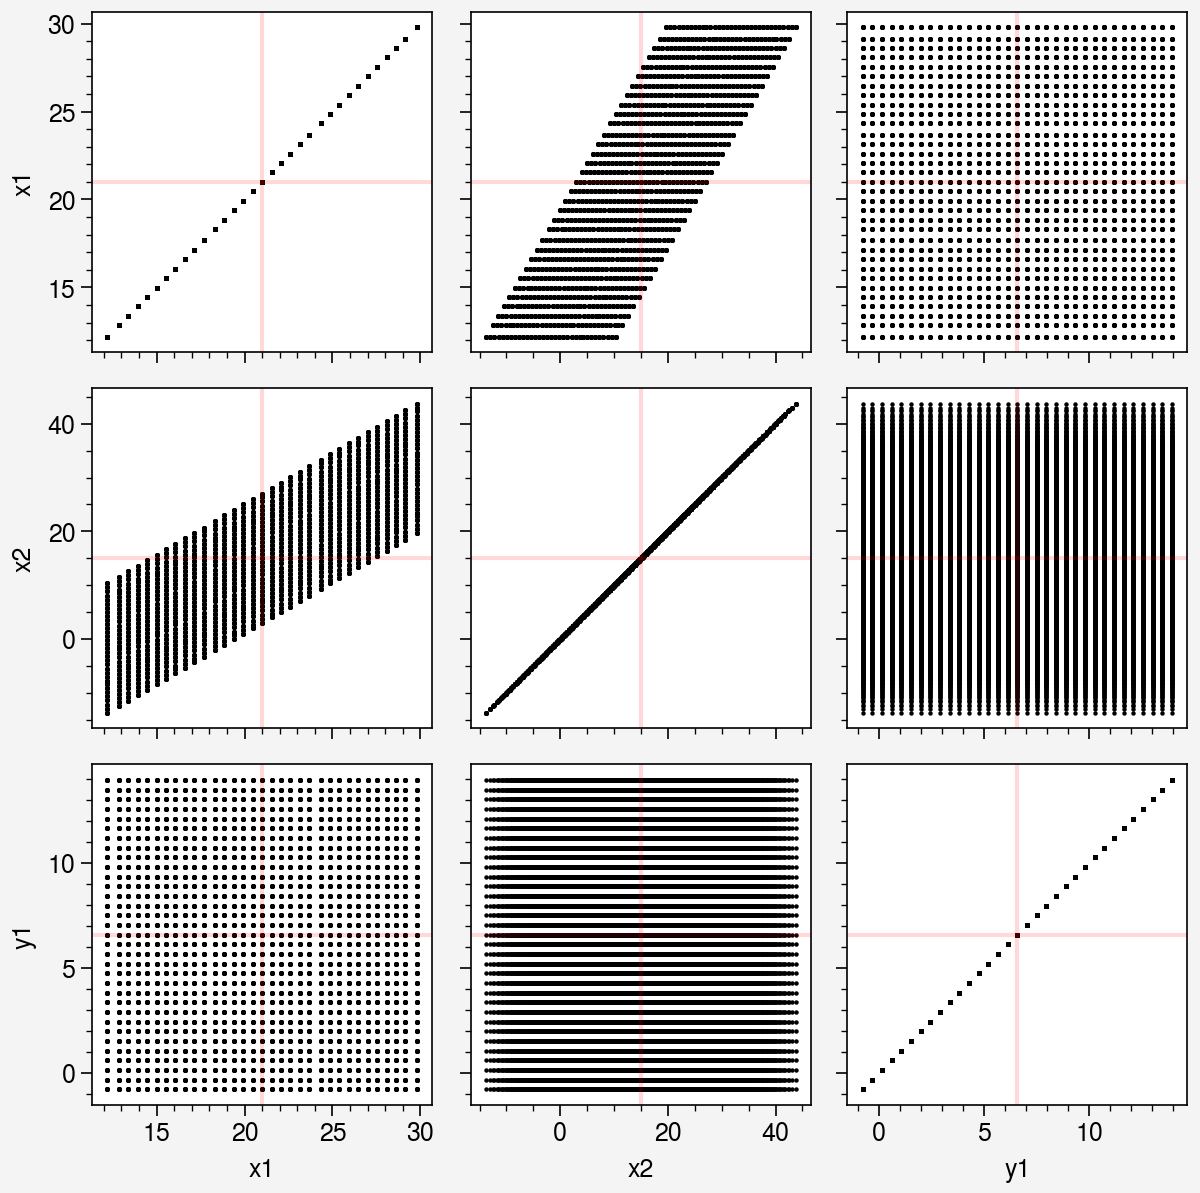

In [11]:
fig, axes = pplt.subplots(nrows=3, ncols=3, figwidth=6, spanx=False, spany=False)
for i in range(3):
    for j in range(3):
        U = coords_3d[j]
        V = coords_3d[i]
        ax = axes[i, j]
        ax.scatter(U.ravel(), V.ravel(), s=1, color='black')
        ax.axvline(np.mean(U), color='red', alpha=0.15)
        ax.axhline(np.mean(V), color='red', alpha=0.15)
    axes[i, 0].format(ylabel=dims[i])
    axes[-1, i].format(xlabel=dims[i])
plt.show()

Copy the grids to cover five dimensions.

In [12]:
X1, X2, Y1 = coords_3d
X1 = utils.copy_into_new_dim(X1, shape[3:], axis=-1)
X2 = utils.copy_into_new_dim(X2, shape[3:], axis=-1)
Y1 = utils.copy_into_new_dim(Y1, shape[3:], axis=-1)

In [13]:
print('X1.shape =', X1.shape)
print('X2.shape =', X2.shape)
print('Y1.shape =', Y1.shape)

X1.shape = (33, 33, 33, 74, 98)
X2.shape = (33, 33, 33, 74, 98)
Y1.shape = (33, 33, 33, 74, 98)


In [14]:
Y3, X3 = np.meshgrid(np.arange(shape[3]), np.arange(shape[4]), indexing='ij')
Y3 = utils.copy_into_new_dim(Y3, shape[:3], axis=0)
X3 = utils.copy_into_new_dim(X3, shape[:3], axis=0)

In [15]:
print('Y3.shape =', Y3.shape)
print('X3.shape =', X3.shape)

Y3.shape = (33, 33, 33, 74, 98)
X3.shape = (33, 33, 33, 74, 98)


Make list of center coordinates. `coords_` has coordinates in raw slit values.

In [16]:
X1 = X1 - np.mean(X1)
X2 = X2 - np.mean(X2)
Y1 = Y1 - np.mean(Y1)
Y3 = Y3 - np.mean(Y3)
X3 = X3 - np.mean(X3)
coords_ = [X1, X2, Y1, Y3, X3]

In [17]:
for i, dim in enumerate(dims):
    print('dim =', dim)
    U = coords_[i]
    axes = [k for k in range(U.ndim) if k != i]
    idx = utils.make_slice(U.ndim, axes, ind=[0, 0, 0, 0])
    print(U[idx])
    print()

dim = x1
[-8.79636364e+00 -8.15272727e+00 -7.61636364e+00 -7.08000000e+00
 -6.54363636e+00 -6.00727273e+00 -5.47090909e+00 -4.93454545e+00
 -4.39818182e+00 -3.86181818e+00 -3.32545455e+00 -2.68181818e+00
 -2.14545455e+00 -1.60909091e+00 -1.07272727e+00 -5.36363636e-01
  2.99138492e-12  5.36363636e-01  1.07272727e+00  1.60909091e+00
  2.14545455e+00  2.68181818e+00  3.32545455e+00  3.86181818e+00
  4.39818182e+00  4.93454545e+00  5.47090909e+00  6.00727273e+00
  6.54363636e+00  7.08000000e+00  7.61636364e+00  8.15272727e+00
  8.79636364e+00]

dim = x2
[-28.7409503  -28.00754424 -27.27413818 -26.39405091 -25.66064485
 -24.92723879 -24.19383273 -23.46042667 -22.72702061 -21.99361455
 -21.26020848 -20.52680242 -19.64671515 -18.91330909 -18.17990303
 -17.44649697 -16.71309091 -15.97968485 -15.24627879 -14.51287273
 -13.77946667 -12.89937939 -12.16597333 -11.43256727 -10.69916121
  -9.96575515  -9.23234909  -8.49894303  -7.76553697  -7.03213091
  -6.15204364  -5.41863758  -4.68523152]

dim =

## View 5D array in slit-screen coordinates

Correlation between planes is removed... units are dimensionless.

### Projections 

In [18]:
frac_thresh = 1e-5

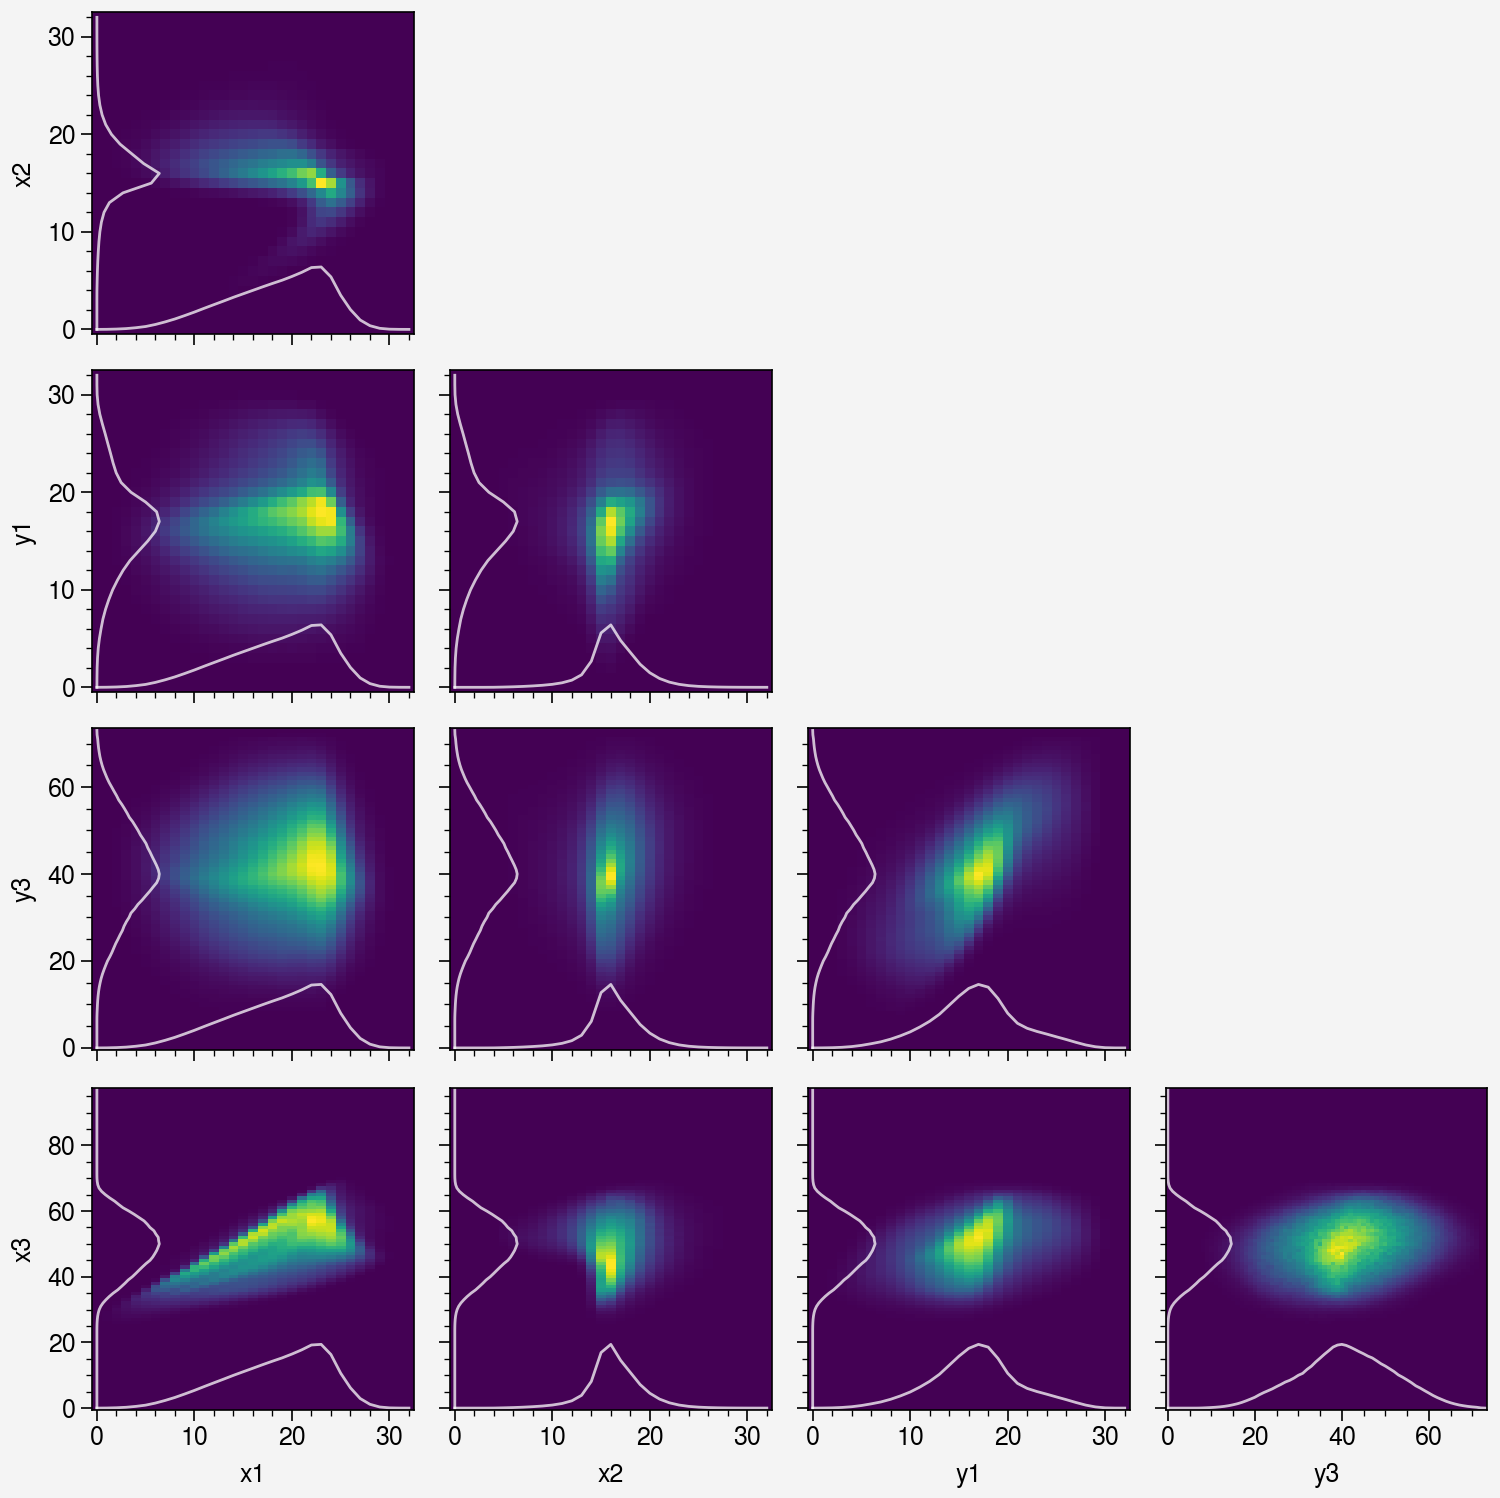

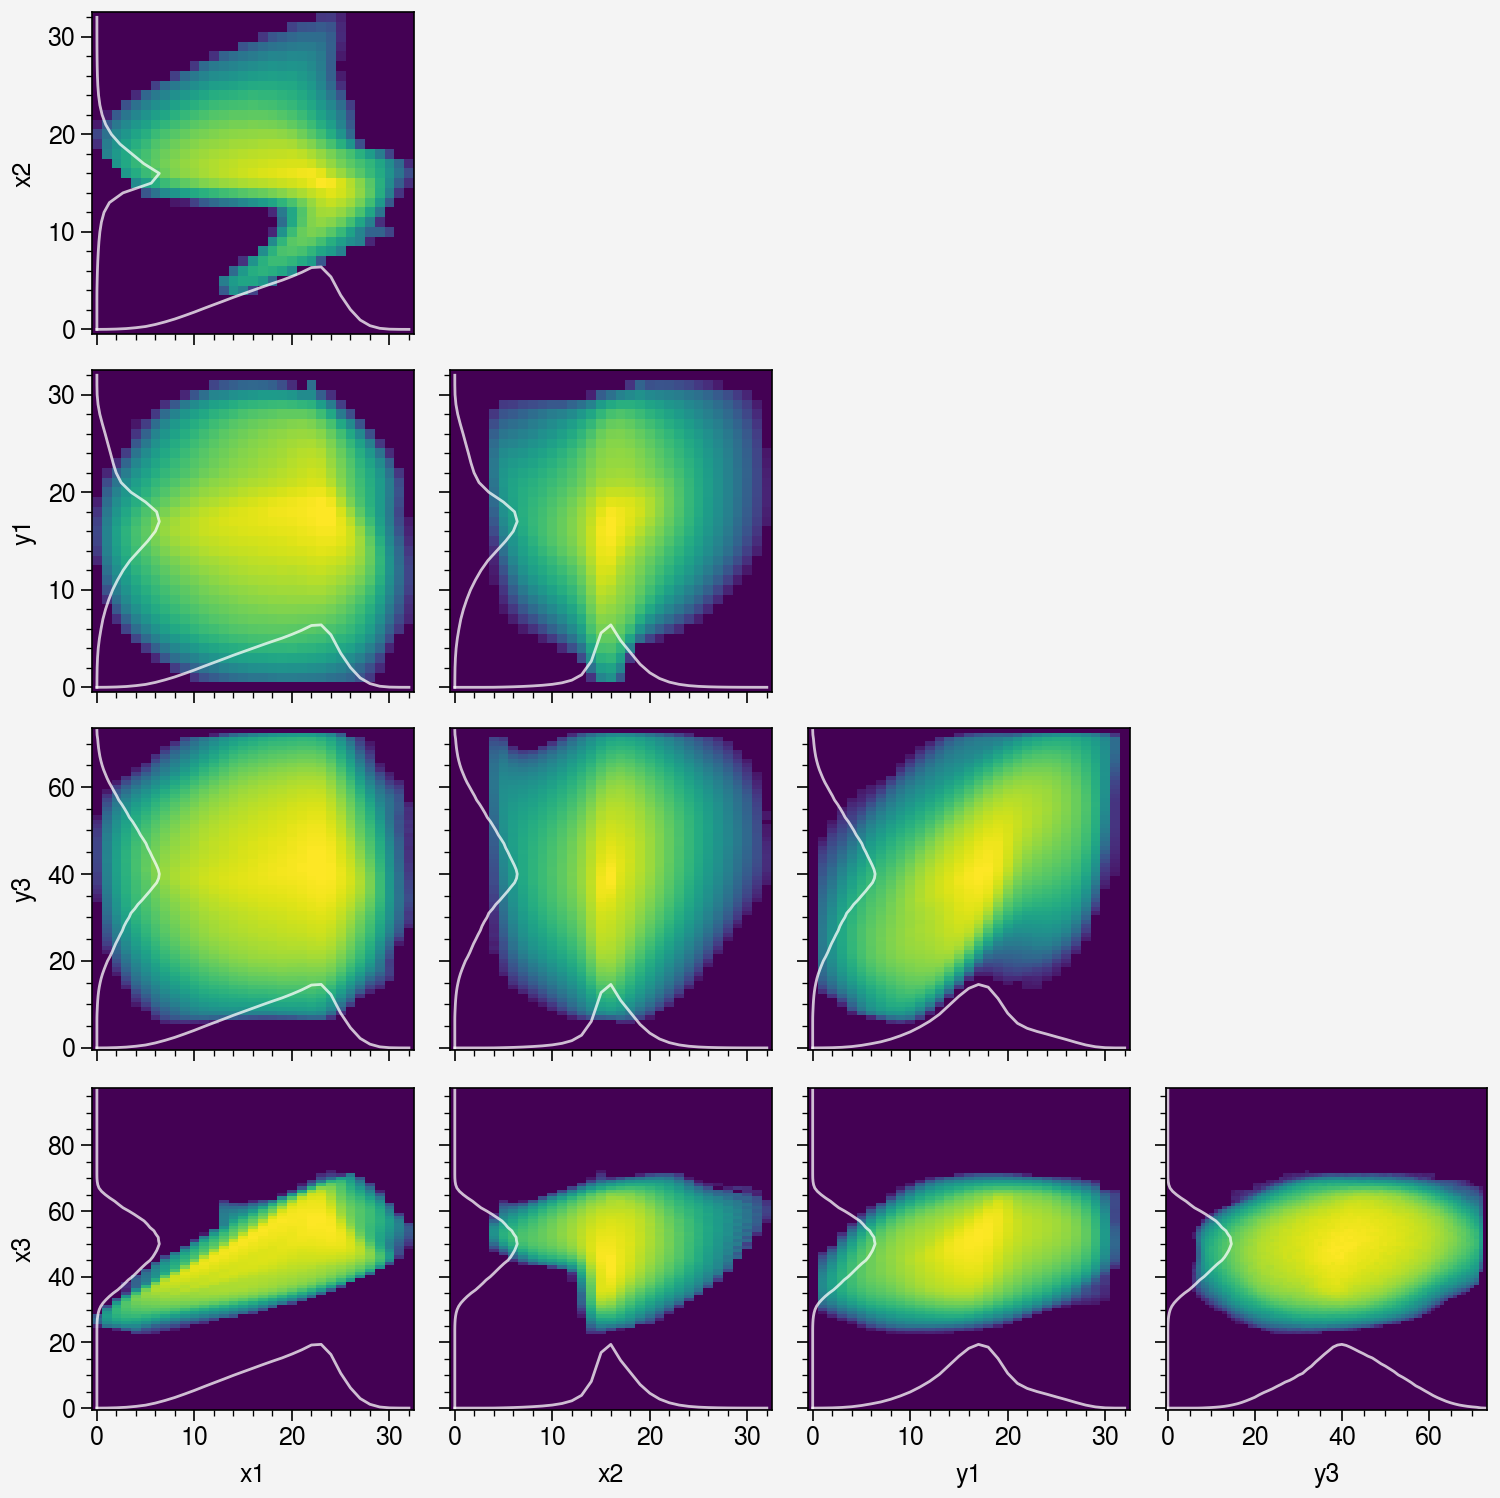

In [20]:
for norm in [None, 'log']:
    axes = mplt.corner(
        a5d,
        labels=dims,
        norm=norm,
        diag_kind='None',
        prof=True,
        prof_kws=dict(lw=1.0, alpha=0.75),
        fig_kws=dict(),
        frac_thresh=frac_thresh,
    )
    plt.savefig(f"_output/corner_log{norm == 'log'}.png")
    plt.show()

### Slices

Compute the indices of the maximum pixel in the 5D array.

In [21]:
ind = np.unravel_index(np.argmax(a5d), a5d.shape)
ind = tuple([i for i in ind])
print(ind)

(22, 17, 19, 44, 63)


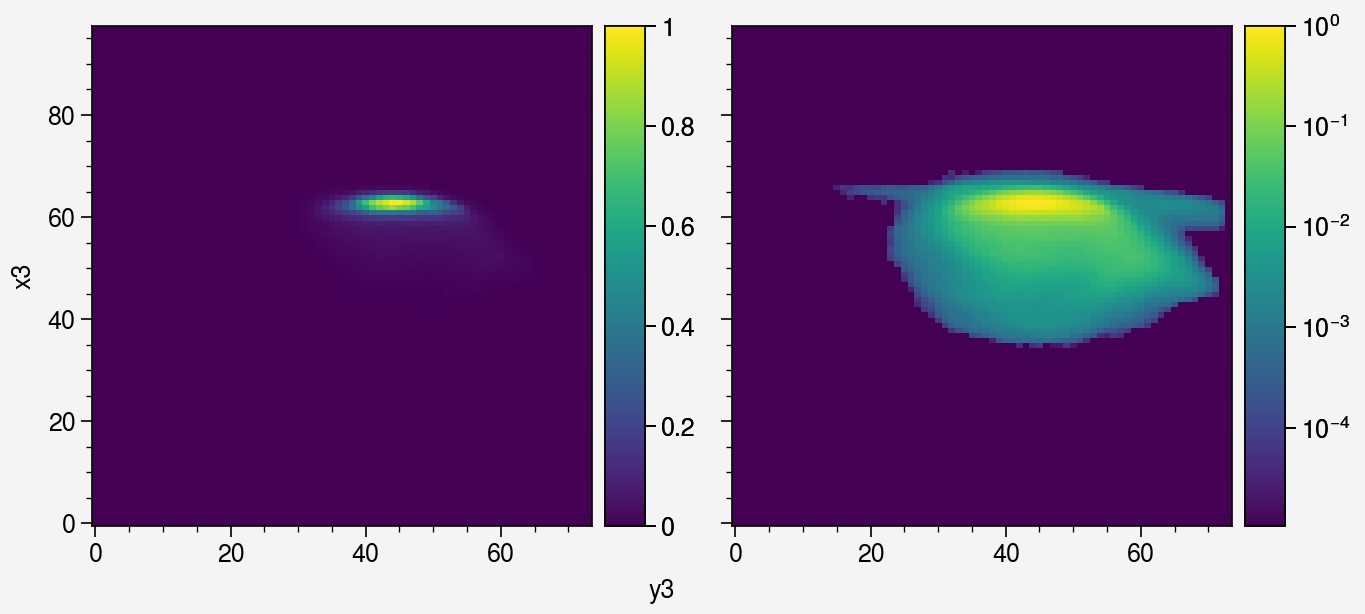

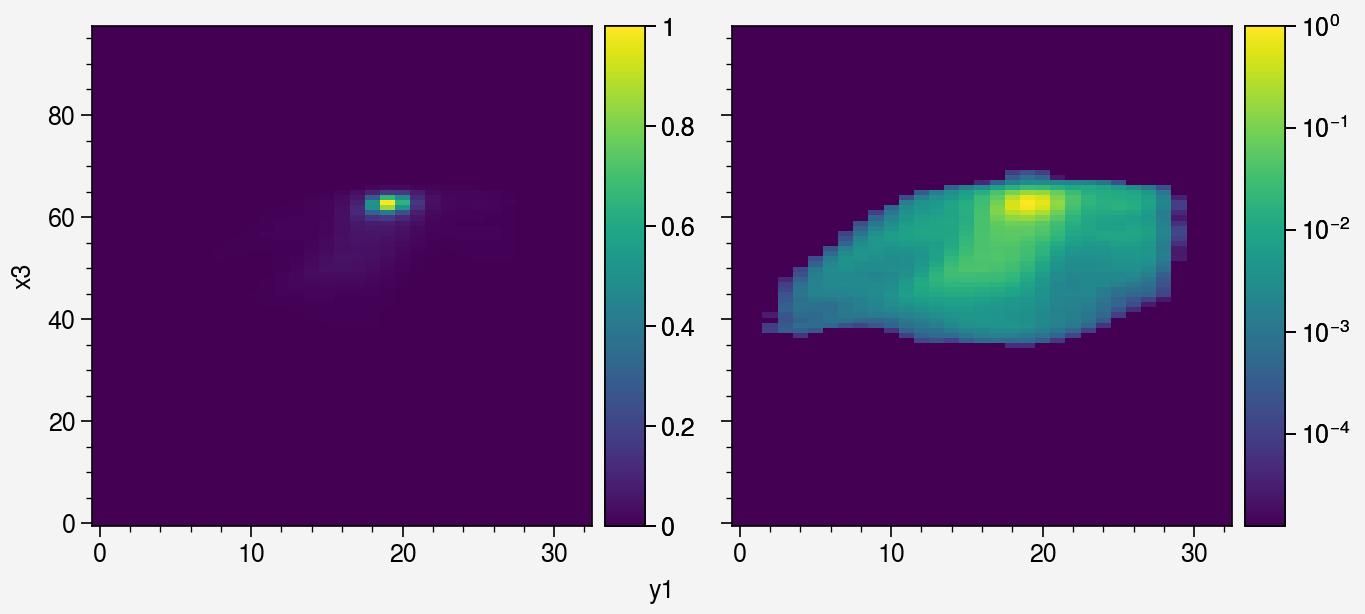

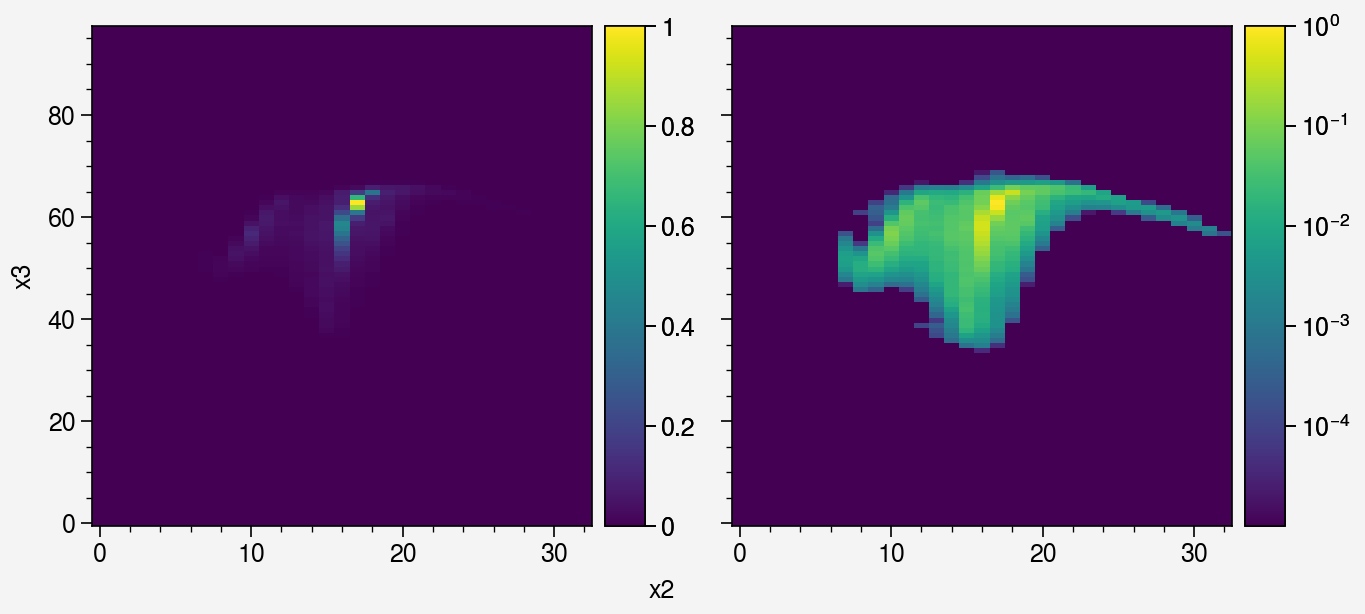

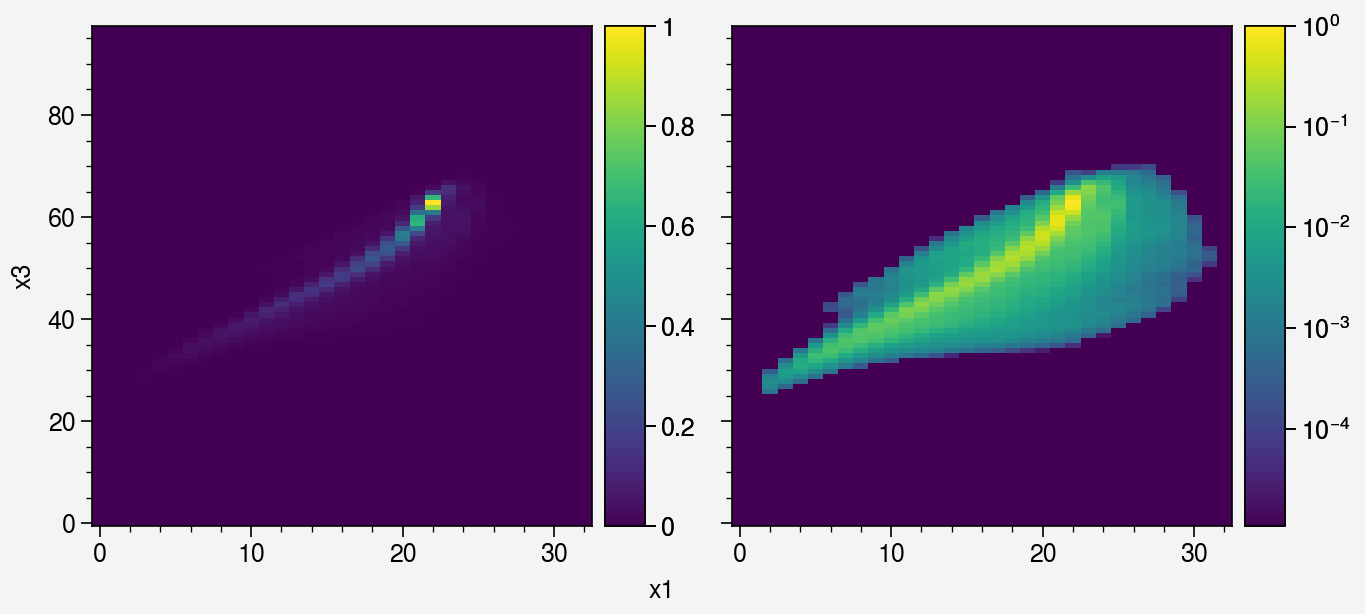

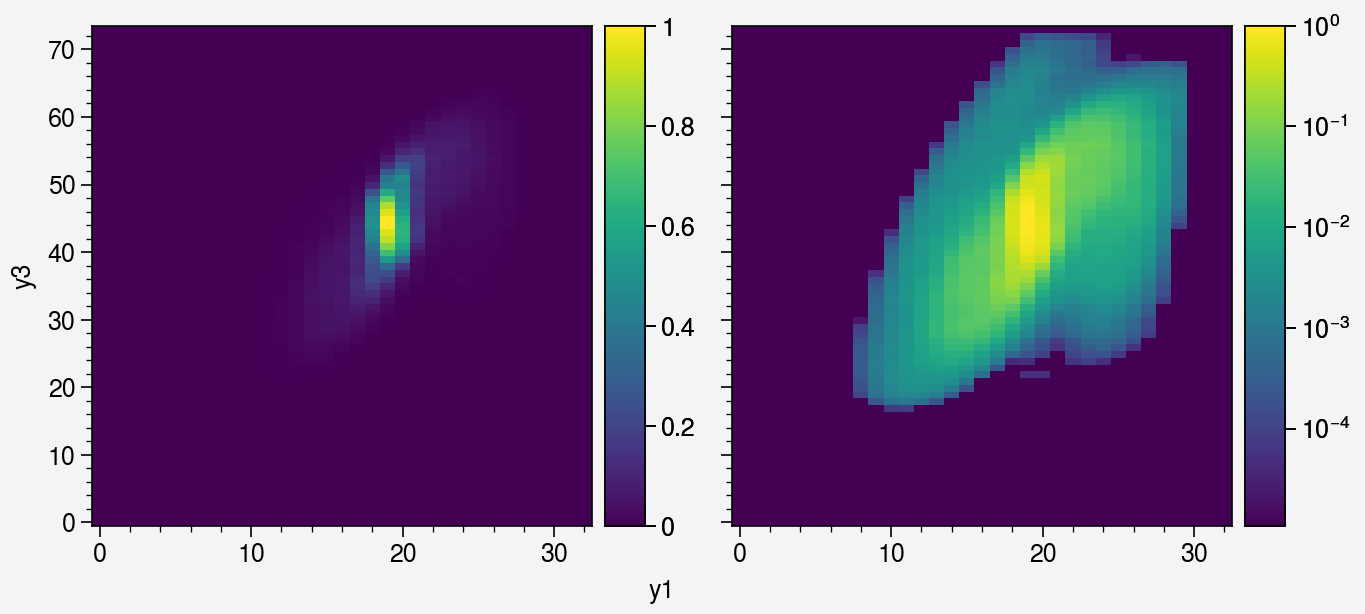

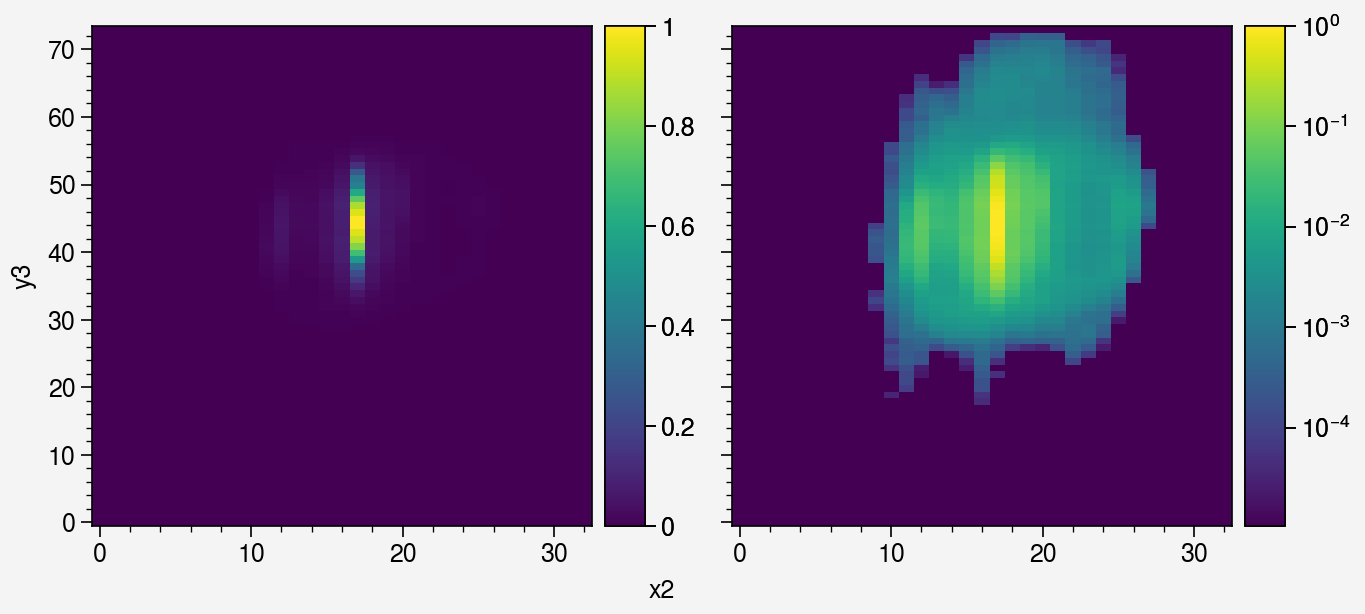

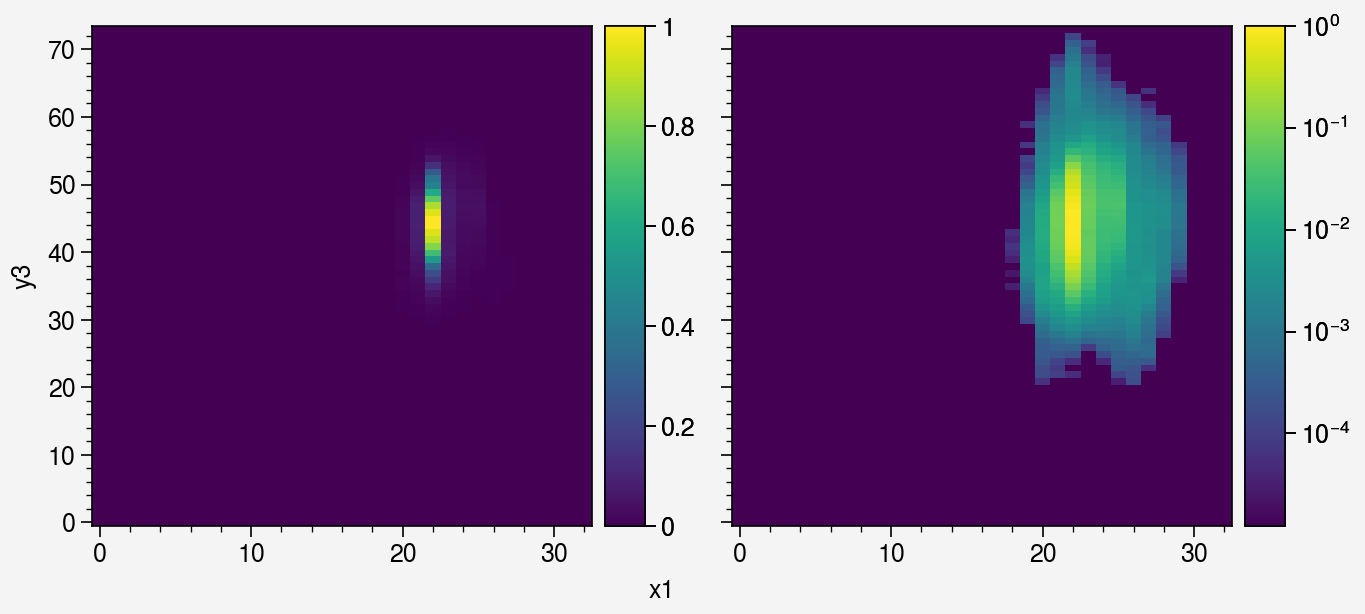

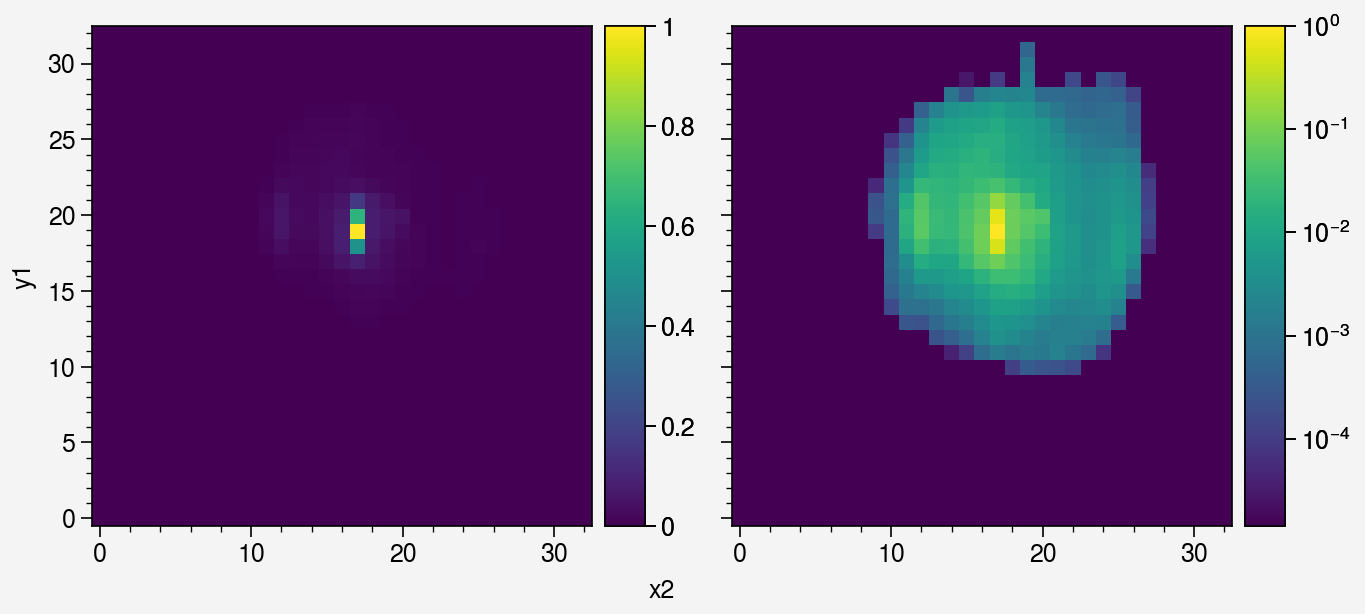

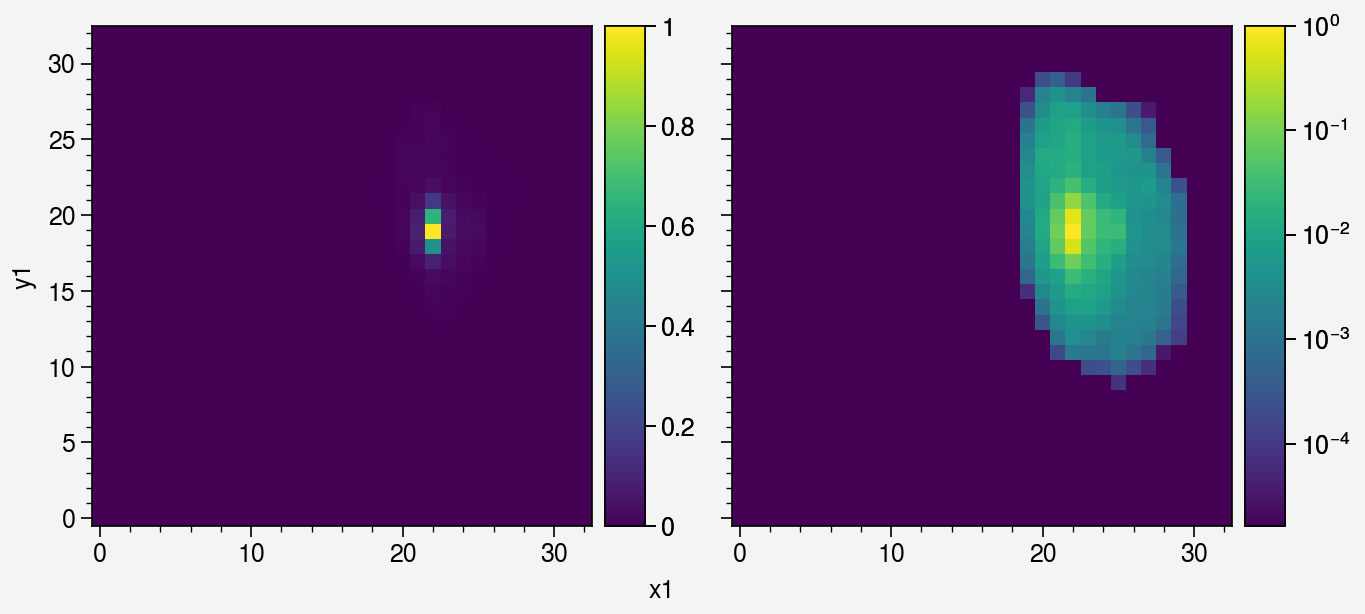

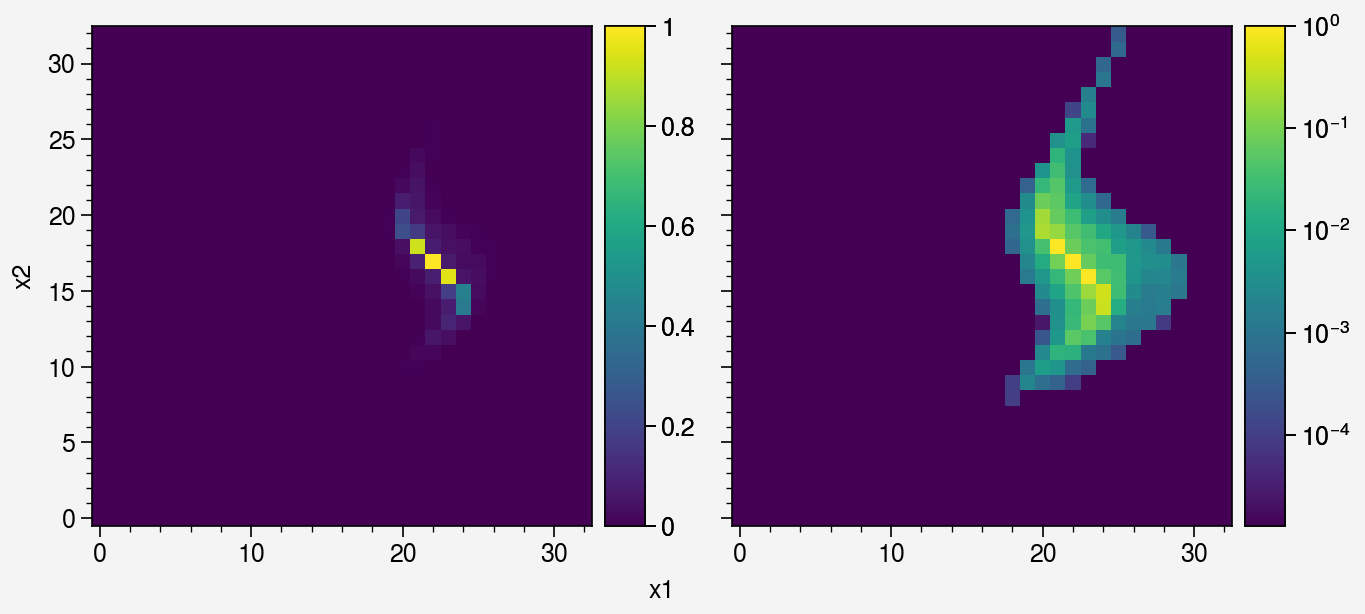

In [22]:
axes_slice = [(k, j, i) for i in range(a5d.ndim) for j in range(i) for k in range(j)]
axes_view = [tuple([i for i in range(a5d.ndim) if i not in axis])
             for axis in axes_slice]
for axis, axis_view in zip(axes_slice, axes_view):
    idx = utils.make_slice(5, axis, [ind[i] for i in axis])
    a5d_slice = a5d[idx]
    a5d_slice = a5d_slice / np.max(a5d_slice)

    dim1, dim2 = [dims[i] for i in axis_view]
    
    fig, plot_axes = pplt.subplots(ncols=2)
    for ax, norm in zip(plot_axes, [None, 'log']):
        mplt.plot_image(a5d_slice, ax=ax, frac_thresh=frac_thresh, norm=norm, colorbar=True)
    plot_axes.format(xlabel=dim1, ylabel=dim2)
    string = '_output/slice_'
    for i in axis:
        string += f'_{dims[i]}-{ind[i]}'
    plt.savefig(string + '.png')
    plt.show()

### Interactive 

In [23]:
cmaps = ['viridis', 'dusk_r', 'mono_r', 'grays', 'plasma', 'blues_r', 'rocket', 'mako', 'stellar_r',]

In [24]:
def update_projection(a5d, dim1='y3', dim2='x3', cfix=False, log=False, reverse=False, **plot_kws):
    if dim1 == dim2:
        raise ValueError('dim1 == dim2')
    dims = [dim1, dim2]
    norm = 'log' if log else None
    plot_kws['cmap'] = pplt.Colormap(plot_kws.pop('cmap'), reverse=reverse)
    image = utils.project(a5d, axis=[dim_to_int[dim] for dim in dims])
    image = image / image.max()
    fig, ax = pplt.subplots()
    mplt.plot_image(image, ax=ax, profx=True, profy=True, prof_kws=dict(scale=0.15), 
                    colorbar=True, norm=norm, **plot_kws)
    ax.format(xlabel=dim1, ylabel=dim2)
    plt.show()

In [25]:
fig = go.FigureWidget()
heatmap = fig.add_heatmap()

@interact(dim1=dims, dim2=dims, cmap=cmaps, reverse=False, log=False, discrete=False)
def update(dim1='y3', dim2='x3', cmap='viridis', reverse=False, log=False, discrete=False):
    with fig.batch_update():
        heatmap.data = update_projection(
            a5d, dim1=dim1, dim2=dim2, log=log, discrete=discrete,
            cmap=cmap, frac_thresh=frac_thresh, reverse=reverse,
        )

interactive(children=(Dropdown(description='dim1', index=3, options=('x1', 'x2', 'y1', 'y3', 'x3'), value='y3'…

## Coordinate transform

Convert x3 and y3 from pixels to mm.

In [26]:
cam = 'Cam34'
cam_settings = ip.camera_settings(cam)
zoom = 0.5
pix2mm = cam_settings.pix2mm / zoom
print(f'pix2mm = {pix2mm} (zoom = {zoom})')

downscale_factor = int(np.loadtxt(join(folder, 'processed_image_downscale_factor.txt')))
pix2mm *= downscale_factor
print(f'pix2mm = {pix2mm} (with downscale_factor = {downscale_factor})')

pix2mm = 0.1 (zoom = 0.5)
pix2mm = 0.4 (with downscale_factor = 4)


In [27]:
X3 = X3 * pix2mm
Y3 = Y3 * pix2mm

Build the transfer matrices between the slits and the screen.

In [28]:
a2mm = 1.009  # assume same as first dipole
rho = 0.3556
GL05 = 0.0
GL06 = 0.0
l1 = 0.0
l2 = 0.0
l3 = 0.774
L2 = 0.311  # slit2 to dipole face
l = 0.129  # dipole face to VS06 screen (assume same for first/last dipole-screen)
LL = l1 + l2 + l3 + L2  # distance from emittance plane to dipole entrance

ecalc = energy.EnergyCalculate(l1=l1, l2=l2, l3=l3, L2=L2, l=l, amp2meter=a2mm*1e3)
Mslit = ecalc.getM1()  # slit-slit
Mscreen = ecalc.getM()  # slit-screen

Compute x', y', and energy w.

In [29]:
Y = Y1.copy()
YP = ecalc.calculate_yp(Y * 1e-3, Y3 * 1e-3, Mscreen)
print('Done with yp.')

X = X1.copy()
XP = ecalc.calculate_xp(X * 1e-3, X2 * 1e-3, Mslit)
print('Done with xp.')

W = ecalc.calculate_dE_screen(X3 * 1e-3, 0.0, X * 1e-3, XP * 1e-3, Mscreen)  # [MeV]
print('Done with w.')

# Convert x-x'/y-y' from m-rad to mm-mrad. 
YP *= 1e3
XP *= 1e3

Done with yp.
Done with xp.
Done with w.


In [30]:
del(X1, X2, Y1, X3, Y3)

Make list of centered phase space coordinate grids.

In [31]:
coords = [X, XP, Y, YP, W]
for coord in tqdm(coords):
    coord = coord - np.mean(coord)

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


## Interpolation 

In [112]:
new_shape = np.array(shape).astype(float)
new_shape[0] *= 1.1
new_shape[1] *= 1.75
new_shape[2] *= 1.1
new_shape = tuple(new_shape.astype(int))
print(new_shape)

np.savetxt('a5d_new_shape.txt', new_shape)

(36, 57, 36, 74, 98)


In [113]:
x_gv_new = np.linspace(np.min(X), np.max(X), new_shape[0])
xp_gv_new = np.linspace(np.min(XP), np.max(XP), new_shape[1])
y_gv_new = np.linspace(np.min(Y), np.max(Y), new_shape[2])
yp_gv_new = np.linspace(np.min(YP), np.max(YP), new_shape[3])
w_gv_new = np.linspace(np.min(W), np.max(W), new_shape[4])
new_coords = [x_gv_new, xp_gv_new, y_gv_new, yp_gv_new, w_gv_new]

utils.save_stacked_array('coords.npz', new_coords)

### Test: put 2D projected phase spaces projection on upright grid

H_new.min() = 0.0


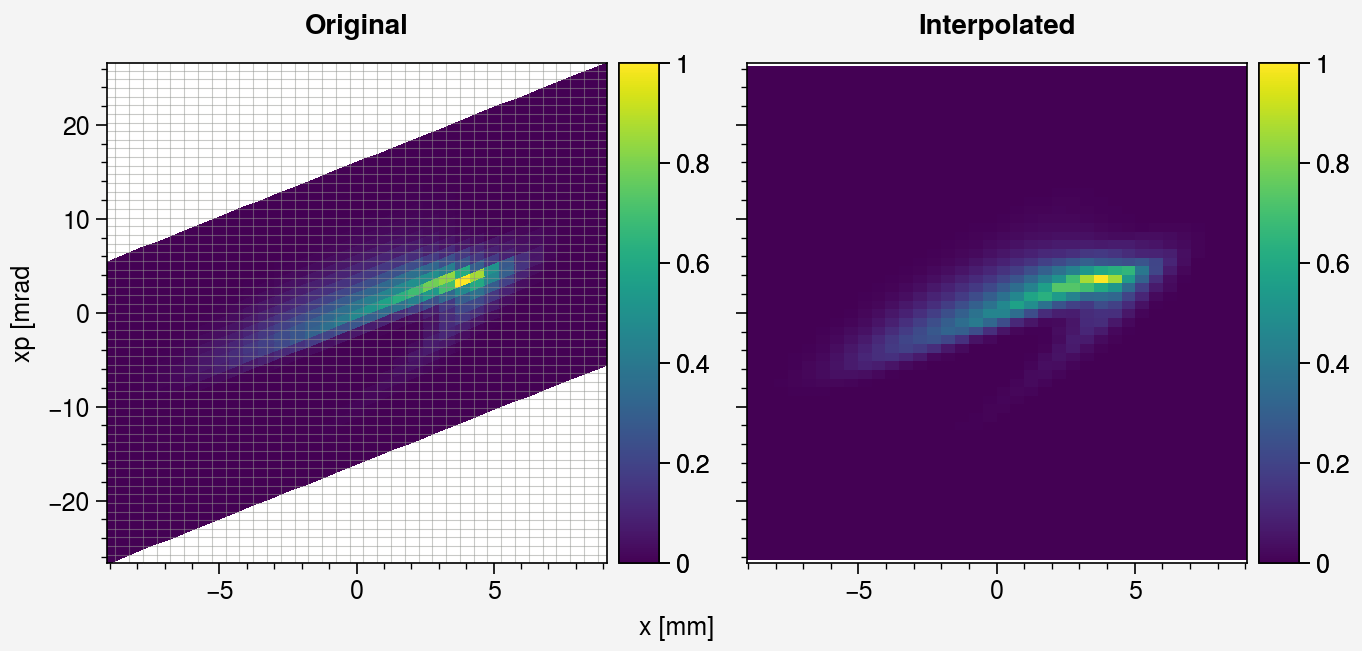

H_new.min() = -1.347086856163701e-19


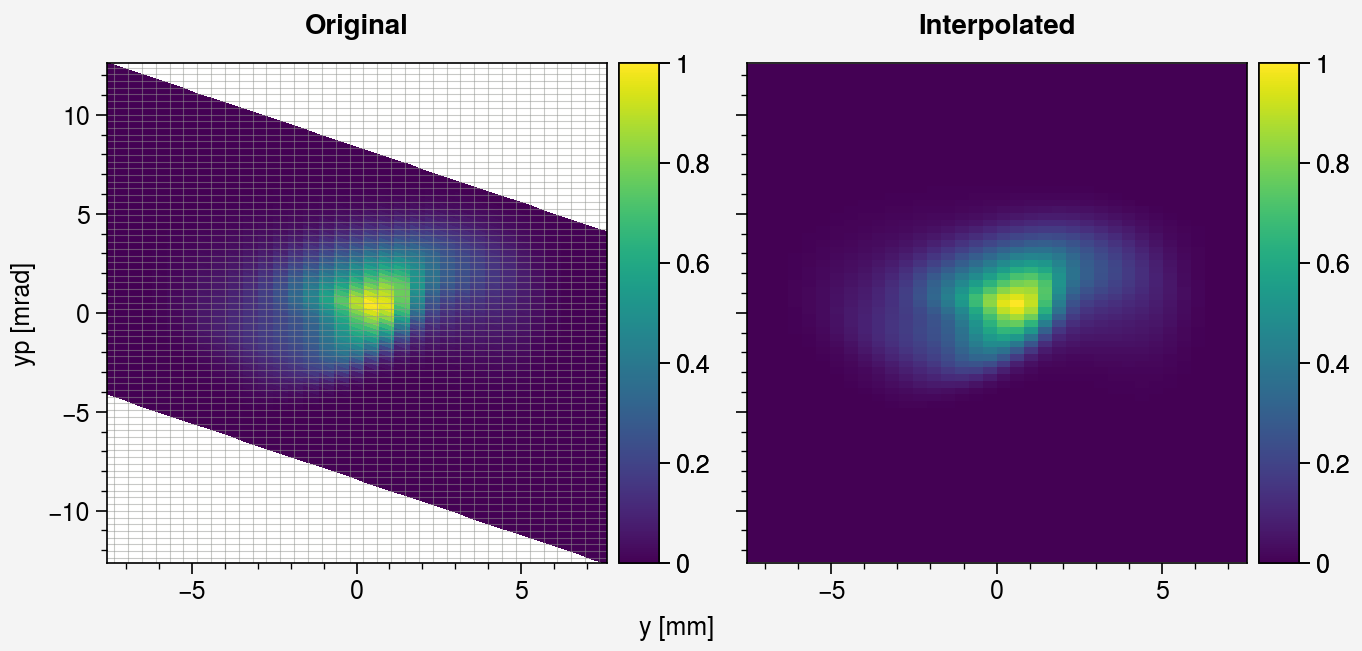

In [114]:
grid = True
contour = False

gvs = [x_gv_new, xp_gv_new, y_gv_new, yp_gv_new]
pdims = ["x [mm]", "xp [mrad", "y [mm]", "yp [mrad]", "w [MeV]"]
for plane, (i, j) in zip(['x', 'y'], [(0, 1), (2, 3)]):
    if plane == 'x':
        U = X[:, :, 0, 0, 0]
        V = XP[:, :, 0, 0, 0]
    elif plane == 'y':
        U = Y[0, 0, :, :, 0]
        V = YP[0, 0, :, :, 0]
    H = utils.project(a5d, axis=(i, j))
    H = H / np.max(H)
    
    points = (U.ravel(), V.ravel())
    values = H.ravel()
    U_new, V_new = np.meshgrid(gvs[i], gvs[j], indexing='ij')
    new_points = (U_new.ravel(), V_new.ravel())
    new_values = interpolate.griddata(points, values, new_points, fill_value=0.0, method='linear')
    H_new = new_values.reshape(len(gvs[i]), len(gvs[j]))
    print(f'H_new.min() = {H_new.min()}')
    H_new = np.clip(H_new, 0.0, None)
    H_new = H_new / np.max(H_new)

    fig, axes = pplt.subplots(ncols=2)
    axes[0].pcolormesh(U.T, V.T, H.T, colorbar=True)
    axes[1].pcolormesh(gvs[i], gvs[j], H_new.T, colorbar=True)
    if grid:
        kws = dict(c='grey', lw=0.4, alpha=0.5)
        for g in gvs[i]:
            axes[0].axvline(g, **kws)
        for g in gvs[j]:
            axes[0].axhline(g, **kws)
    if contour:
        axes[1].contour(U.T, V.T, H.T, color='white', alpha=0.2, lw=0.75)
    axes.format(xlabel=pdims[i], ylabel=pdims[j], toplabels=['Original', 'Interpolated'])
    plt.show()

As a result of shearing, xp actually covers 33 cells in rougly 1.75 of the final grid dimensions. So we can get away with boosting the phase space resolution!

### Direct 5D interpolation 

It is unknown how long this takes. Skip.

In [115]:
# points = tuple([U.ravel() for U in [X, XP, Y, YP, W]])
# values = a5d.ravel()
# new_points = tuple(
#     [U.ravel() for U in np.meshgrid(x_gv_new, xp_gv_new,
#                                     y_gv_new, yp_gv_new, 
#                                     w_gv_new, indexing='ij')]
# )
# a5d_new = interpolate.griddata(points, values, new_points, 
#                                fill_value=0.0, method='linear')

### Interpolate w for each (x, x', y, y') 

In [116]:
a5d_new = np.zeros((shape[0], shape[1], shape[2], shape[3], new_shape[4]))

In [ ]:
new_points = w_gv_new
for i in trange(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            for l in range(shape[3]):
                points = coords[4][i, j, k, l, :]
                values = a5d[i, j, k, l, :]
                a5d_new[i, j, k, l, :] = interpolate.griddata(
                    points, 
                    values, 
                    new_points, 
                    fill_value=0.0, 
                    method='linear',
                )

 67%|██████▋   | 22/33 [02:29<01:13,  6.71s/it]

Redefine the grid coordinates — copy the x, x', y, and y' grids along the new w axis.

In [ ]:
X = utils.copy_into_new_dim(X[:, :, :, :, 0], (new_shape[4],), axis=-1)
Y = utils.copy_into_new_dim(Y[:, :, :, :, 0], (new_shape[4],), axis=-1)
XP = utils.copy_into_new_dim(XP[:, :, :, :, 0], (new_shape[4],), axis=-1)
YP = utils.copy_into_new_dim(YP[:, :, :, :, 0], (new_shape[4],), axis=-1)
W = utils.copy_into_new_dim(w_gv_new, (shape[0], shape[1], shape[2], shape[3]), axis=0)
coords = [X, XP, Y, YP, W]

In [ ]:
for C in coords:
    print(C.shape)

### Interpolate x-x' for each (y, y', w)

In [ ]:
a5d_new = np.zeros((new_shape[0], new_shape[1], shape[2], shape[3], new_shape[4]))
new_points = tuple([G.ravel() for G in np.meshgrid(x_gv_new, xp_gv_new, indexing='ij')])
for k in trange(a5d.shape[2]):
    for l in range(a5d.shape[3]):   
        for m in range(a5d.shape[4]):
            points = (
                coords[0][:, :, k, l, m].ravel(),
                coords[1][:, :, k, l, m].ravel(),
            )
            values = a5d[:, :, k, l, m].ravel()
            new_values = interpolate.griddata(
                points,
                values,
                new_points,
                fill_value=0.0,
                method='linear',
            )
            a5d_new[:, :, k, l, m] = new_values.reshape((new_shape[0], new_shape[1]))

In [ ]:
a5d = a5d_new.copy()

Same thing with the coordinates. We now need to copy the x-x' grid along all other dimensions, and y, y', and w along the x and x' dimensions.

In [ ]:
_X, _XP = np.meshgrid(x_gv_new, xp_gv_new, indexing='ij')
X = utils.copy_into_new_dim(_X, (shape[2], shape[3], new_shape[4]), axis=-1)
XP = utils.copy_into_new_dim(_XP, (shape[2], shape[3], new_shape[4]), axis=-1)
Y = utils.copy_into_new_dim(Y[0, 0, :, :, :], (new_shape[0], new_shape[1]), axis=0)
YP = utils.copy_into_new_dim(YP[0, 0, :, :, :], (new_shape[0], new_shape[1]), axis=0)
W = utils.copy_into_new_dim(W[0, 0, :, :, :], (new_shape[0], new_shape[1]), axis=0)
coords = [X, XP, Y, YP, W]

In [ ]:
for C in coords:
    print(C.shape)

### Interpolate y-y' for each (x, x', w)

In [ ]:
a5d_new = np.memmap('a5d_new.mmp', shape=new_shape, dtype='float', mode='w+') 
new_points = tuple([G.ravel() for G in np.meshgrid(y_gv_new, yp_gv_new, indexing='ij')])
for i in trange(new_shape[0]):
    for j in range(new_shape[1]):   
        for m in range(new_shape[4]):
            points = (
                coords[2][i, j, :, :, m].ravel(),
                coords[3][i, j, :, :, m].ravel(),
            )
            values = a5d[i, j, :, :, m].ravel()
            new_values = interpolate.griddata(
                points,
                values,
                new_points,
                fill_value=0.0,
                method='linear',
            )
            a5d_new[i, j, :, :, m] = new_values.reshape((new_shape[2], new_shape[3]))

In [ ]:
del a5d_new